## 1.Load the data, deu-eng.txt Download deu-eng.txt, into memory and clean and prepare the data.

In [ ]:
import os
import random
import numpy as np
import tensorflow as tf
from tensorflow import keras
SEED = 101
os.environ['PYTHONHASHSEED']=str(SEED)
os.environ['TF_CUDNN_DETERMINISTIC'] = '1'
random.seed(SEED)
np.random.seed(SEED)
tf.random.set_seed(SEED)

In [ ]:
# Set the batch size
batch_size = 64
# Set the epochs number
epochs = 100
# Latent dimensionality of the encoding space.
latent_dim = 256
# Number of samples to use.
num_samples = 10000
# Data file
data_path = "/content/deu-eng.txt"

In [ ]:
# Obtain the features (input) and labels (target)
input_texts = []
target_texts = []
# Unique characters in the inputs and targets
input_characters = set()
target_characters = set()
# Load the data into memory
with open(data_path, "r", encoding="utf-8") as f:
    lines = f.read().split("\n")
# Process line by line
for line in lines[: min(num_samples, len(lines) - 1)]:
    # Data format English + TAB + The Other Language + TAB + Attribution
    # It returns: English, The other language, and Attribution, which is discarded
    input_text, target_text, _ = line.split("\t")
    # We use "tab" as the "start sequence" character
    # for the targets, and "\n" as "end sequence" character.
    target_text = "\t" + target_text + "\n"
    input_texts.append(input_text)
    target_texts.append(target_text)
    # Get the unique char from the input texts
    for char in input_text:
        if char not in input_characters:
            input_characters.add(char)
    # Get the unique char from the target texts
    for char in target_text:
        if char not in target_characters:
            target_characters.add(char)

In [ ]:
input_characters = sorted(list(input_characters))
target_characters = sorted(list(target_characters))
num_encoder_tokens = len(input_characters)
num_decoder_tokens = len(target_characters)
max_encoder_seq_length = max([len(txt) for txt in input_texts])
max_decoder_seq_length = max([len(txt) for txt in target_texts])

print(f'Number of samples:= {len(input_texts)}')
print(f"Number of unique input tokens: = {num_encoder_tokens}")
print(f"Number of unique output tokens: = {num_decoder_tokens}")
print(f"Max sequence length for inputs: = {max_encoder_seq_length}")
print(f"Max sequence length for outputs: = {max_decoder_seq_length}")


Number of samples:= 10000
Number of unique input tokens: = 71
Number of unique output tokens: = 85
Max sequence length for inputs: = 15
Max sequence length for outputs: = 45


In [ ]:
input_token_index = dict([(char, i) for i, char in enumerate(input_characters)])
target_token_index = dict([(char, i) for i, char in enumerate(target_characters)])

In [ ]:
# Initialize the 3 D matrix
encoder_input_data = np.zeros(
    #num matrixes      rows in each matrix     columns in each matrix
    (len(input_texts), max_encoder_seq_length, num_encoder_tokens), dtype="float32"
)

decoder_input_data = np.zeros(
    (len(target_texts), max_decoder_seq_length, num_decoder_tokens), dtype="float32"
)
decoder_target_data = np.zeros(
    (len(target_texts), max_decoder_seq_length, num_decoder_tokens), dtype="float32"
)

# Convert the input texts and target texts to numerical values
for i, (input_text, target_text) in enumerate(zip(input_texts, target_texts)):
    # Convert input texts to numerical values
    for t, char in enumerate(input_text):
        encoder_input_data[i, t, input_token_index[char]] = 1.0
    # Pad the remaining using space that is mapped to 1
    encoder_input_data[i, t + 1 :, input_token_index[" "]] = 1.0
    # Convert target texts to numerical values
    for t, char in enumerate(target_text):
        # decoder input is used to forecast decoder target
        # decoder_target_data is ahead of decoder_input_data by one timestep
        decoder_input_data[i, t, target_token_index[char]] = 1.0
        if t > 0:
            # decoder_target_data will be ahead by one timestep
            # and will not include the start character.
            decoder_target_data[i, t - 1, target_token_index[char]] = 1.0
    # Pad the remaining using space that is mapped to 1
    decoder_input_data[i, t + 1 :, target_token_index[" "]] = 1.0
    decoder_target_data[i, t:, target_token_index[" "]] = 1.0

## 2.Develop an encoder for the model.

In [ ]:
## Begin Define the encoder layes
# Define an input sequence
encoder_inputs = keras.Input(shape=(None, num_encoder_tokens))
# Define the LSTM which will return the hidden states
encoder = keras.layers.LSTM(latent_dim, return_state=True)
# Apply LSTM and return the ouputs and hidden states
encoder_outputs, state_h, state_c = encoder(encoder_inputs)
# Discard the outputs and only keep the states.
encoder_states = [state_h, state_c]
## End Define the encoder layes


## 3.Develop a decoder for the model.

In [ ]:
## Begin Define the decoder layes
# Define the decoder inputs
decoder_inputs = keras.Input(shape=(None, num_decoder_tokens))

decoder_lstm = keras.layers.LSTM(latent_dim, return_sequences=True, return_state=True)
# Set up the decoder, using `encoder_states` as initial state.
# Kee the outputs and discard the hidden states
decoder_outputs, _, _ = decoder_lstm(decoder_inputs, initial_state=encoder_states)
# Forecast he decoder outputs using a classifier based on the decoder outputs
decoder_dense = keras.layers.Dense(num_decoder_tokens, activation="softmax")
decoder_outputs = decoder_dense(decoder_outputs)
## End Define the decoder layes

## 4.Build the sequence to sequence model.

In [ ]:
# Define the model that will turn
# `encoder_input_data` & `decoder_input_data` into `decoder_target_data`
model = keras.Model([encoder_inputs, decoder_inputs], decoder_outputs)

## 5.Train the model.

In [ ]:
model.compile(
    optimizer="rmsprop", loss="categorical_crossentropy", metrics=["accuracy"]
)

In [ ]:
from tensorflow.keras.callbacks import EarlyStopping
# Setup early stopping criteria
early_stopping = EarlyStopping(
    monitor='val_accuracy',
    patience=5,
    min_delta=0.001,
    mode='max'
)
history = model.fit(
    [encoder_input_data, decoder_input_data],
    decoder_target_data,
    batch_size=batch_size,
    epochs=epochs,
    validation_split=0.2,
    callbacks=[early_stopping],
)
# Save model
model.save("s2s")

Epoch 1/100
125/125 [==============================] - 47s 347ms/step - loss: 1.5863 - accuracy: 0.6360 - val_loss: 1.4853 - val_accuracy: 0.6049
Epoch 2/100
125/125 [==============================] - 46s 365ms/step - loss: 1.2192 - accuracy: 0.6653 - val_loss: 1.2717 - val_accuracy: 0.6410
Epoch 3/100
125/125 [==============================] - 42s 336ms/step - loss: 1.0382 - accuracy: 0.7185 - val_loss: 1.0481 - val_accuracy: 0.7167
Epoch 4/100
125/125 [==============================] - 42s 336ms/step - loss: 0.8997 - accuracy: 0.7510 - val_loss: 0.9623 - val_accuracy: 0.7306
Epoch 5/100
125/125 [==============================] - 43s 348ms/step - loss: 0.8153 - accuracy: 0.7708 - val_loss: 0.8894 - val_accuracy: 0.7507
Epoch 6/100
125/125 [==============================] - 42s 334ms/step - loss: 0.7654 - accuracy: 0.7825 - val_loss: 0.8658 - val_accuracy: 0.7561
Epoch 7/100
125/125 [==============================] - 44s 349ms/step - loss: 0.7458 - accuracy: 0.7876 - val_loss: 0.8166 -

## 6.Evaluate the model and check the model fit.

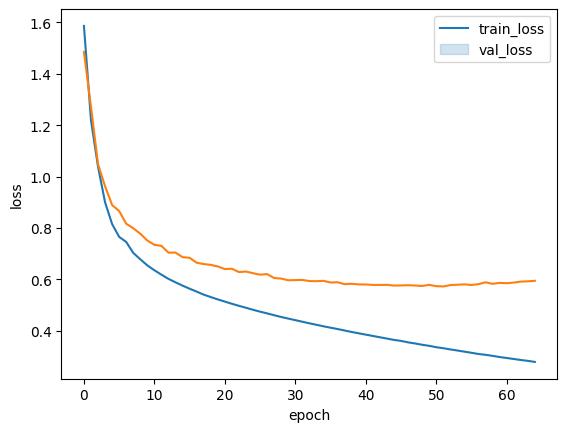

In [ ]:
import seaborn as sns
import pandas as pd
import matplotlib.pyplot as plt

train_history = pd.DataFrame(history.history)
train_history['epoch'] = history.epoch
# Plot train loss
sns.lineplot(x='epoch', y ='loss', data =train_history)
# Plot validation loss
sns.lineplot(x='epoch', y ='val_loss', data =train_history)
# Add legends
plt.legend(labels=['train_loss', 'val_loss'])

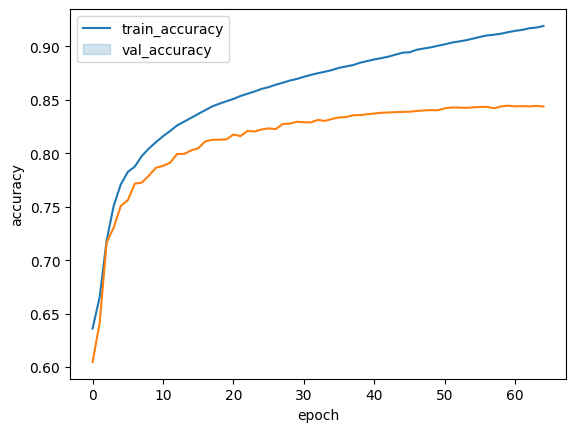

In [ ]:
sns.lineplot(x='epoch', y ='accuracy', data =train_history)
# Plot validation loss
sns.lineplot(x='epoch', y ='val_accuracy', data =train_history)
# Add legends
plt.legend(labels=['train_accuracy', 'val_accuracy'])

## 7.Run the inference.

In [ ]:
model.summary()

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, None, 71)]   0           []                               
                                                                                                  
 input_2 (InputLayer)           [(None, None, 85)]   0           []                               
                                                                                                  
 lstm (LSTM)                    [(None, 256),        335872      ['input_1[0][0]']                
                                 (None, 256),                                                     
                                 (None, 256)]                                                     
                                                                                            

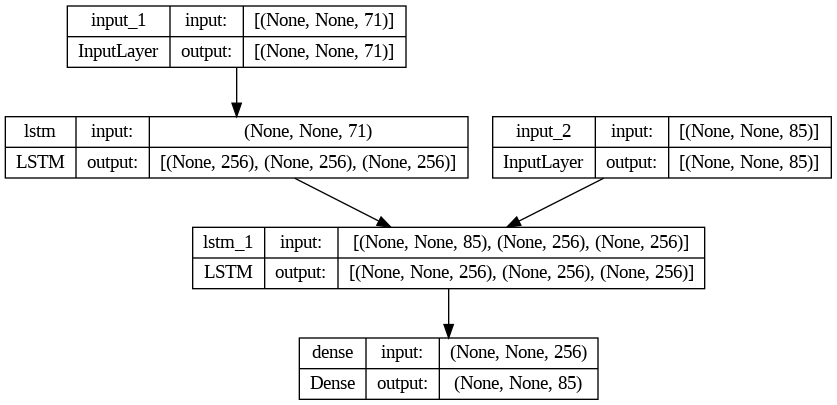

In [ ]:
tf.keras.utils.plot_model(model, show_shapes=True)

In [ ]:
model.layers

In [ ]:
model.input

[<KerasTensor: shape=(None, None, 71) dtype=float32 (created by layer 'input_1')>,
 <KerasTensor: shape=(None, None, 85) dtype=float32 (created by layer 'input_2')>]

In [ ]:
New_input_text = "great"
encoder_input_data = np.zeros(
    (1, max_encoder_seq_length, num_encoder_tokens), dtype="float32"
)

for t, char in enumerate(New_input_text):
    encoder_input_data[0, t, input_token_index[char]] = 1.0
    # Pad the remaining using space that is mapped to 1
    encoder_input_data[0, t + 1 :, input_token_index[" "]] = 1.0